In [3]:
import pandas as pd
import spacy
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import ast
from functools import lru_cache

## Extract location mentions from abstract

In [3]:
df = pd.read_csv('all_papers_clean_abstract.csv')
df = df[['Id','Year','Title','journal_abbr','Abstract_Clean_CH','Author Keywords']]
df.rename(columns={'Abstract_Clean_CH':'Abstract'}, inplace=True)
df

,Id,Year,Title,journal_abbr,Abstract,Author Keywords
0,273,1999,Multisensor remote sensing data for land use/c...,CEUS,Spaceborne radar data have only recently been ...,Land use/cover mapping; Multisensor; Radar; Se...
1,274,1999,Acquiring transition rules between multiple re...,CEUS,Multi-scale representation is an issue of grow...,Database generalization; Machine learning; Mod...
2,275,1999,Accessibility analysis and spatial competition...,CEUS,In this article we discuss different methods t...,Accessibility; Facility siting; Geographic inf...
3,276,1999,Using a genetic algorithm to generate alternat...,CEUS,This paper describes a tool that can assist th...,Genetic algorithm; Multiobjective programming;...
4,277,1999,Pathways of smart metering development: Shapin...,CEUS,Utility meters are being transformed from simp...,Energy; Environmental innovation; Pathways; Pr...
...,...,...,...,...,...,...
5472,9172,2017,Spheroidal equal angular DEMs: The specificity...,TGIS,Digital elevation models (DEMs) are commonly c...,computation; Digital elevation model; error; g...
5473,9173,2017,Context inference and prediction modeling in u...,TGIS,The ever-increasing population in cities inten...,asthma; GIS; prediction; reasoning; ubiquitous...
5474,9260,2019,A web-based visualization tool for exploring s...,TGIS,This article describes an open source web-base...,conflict mapping; land-use planning; multi-cri...
5475,9322,2020,Extending Processing Toolbox for assessing the...,TGIS,OpenStreetMap (OSM) produces a huge amount of ...,Logical consistency; OpenStreetMap; PyQGIS; QGIS


In [4]:
def filter_norp(norp_term):
    
    # list of mathematical/statistical terms commonly misclassified as NORP
    exclude_terms = {
        'gaussian','cartesian', 'bayesian', 'euclidean', 'markovian',
        'boolean', 'hamiltonian', 'laplacian', 'lagrangian', 'jacobian',
        'newtonian', 'poisson', 'riemannian','christallerian','darwinian',
        'pigovian'
    }
    
    # convert to lowercase and check for compound word
    term_lower = norp_term.lower()
    term_parts = term_lower.replace('-', ' ').split()
    
    return not any(part in exclude_terms for part in term_parts)

In [5]:
nlp = spacy.load("en_core_web_trf")

def extract_locations(text):
    
    doc = nlp(text)
    locations = set()

    #retrieve geoentites and cleaned nationalities
    for ent in doc.ents:
        if (ent.label_ == "GPE" or (ent.label_ == "NORP" and filter_norp(ent.text))): 
            if len(ent.text.strip()) > 1:
                locations.add(ent.text)

    # Replace locations from the text with [Location]
    new_text = text
    for location in locations:
        new_text = new_text.replace(location, '[LOCATION]')

    return list(locations), new_text

In [6]:
df[['Locations', 'Abstract_no_locations']] = df['Abstract'].swifter.apply(lambda x: pd.Series(extract_locations(x)))

Pandas Apply:   0%|          | 0/5477 [00:00<?, ?it/s]

In [7]:
# remove the ones without location mentions
df_loc = df[df['Locations'].astype(str) != '[]']

In [13]:
# export extraction location as csv
df_loc.to_csv('all_papers_location.csv',index=False)

## Extract and normalize country names

In [16]:
df_location = pd.read_csv('all_papers_location.csv')
df_location['Locations'] = df_location['Locations'].apply(ast.literal_eval)

def clean_location_name(location):
    # List of prefixes to remove
    prefixes = ["the City of ","the County of ", "the Region of ", "the Community of ",
                "the Greater ","Metropolitan Region", "Metropolitan Area"]
    
    for prefix in prefixes:
        location = location.replace(prefix, "")

    return location.strip()

In [17]:
df_location['Loc'] = df_location['Locations'].apply(lambda locations: [clean_location_name(loc) for loc in locations])

In [18]:
# map nationalities to countries
df_nationality = pd.read_csv('country-nationality.csv')
nat_country_map = dict(zip(df_nationality["Nationality"], df_nationality["Country"]))

# map us state abbr to full name
us_state = pd.read_csv("https://raw.githubusercontent.com/jasonong/List-of-US-States/refs/heads/master/states.csv")
us_state_map = dict(zip(us_state["Abbreviation"], us_state["State"]))

aliases_mapping = {
    "U.S.": "United States",
    "US": "United States",
    "USA": "United States",
    "D.C.": "United States",
    "the United States": "United States",
    "United States of America": "United States",
    "UK": "United Kingdom",
    "U.K.": "United Kingdom",
    "Palestine": "Palestine"
}

# Continental/regional mappings
continental_mappings = {
    "European": "Europe",
    "Western European": "Western Europe",
    "Eastern European": "Eastern Europe",
    "Northern European": "Northern Europe",
    "Southern European": "Southern Europe",
    "Central European": "Central Europe",
        
    "Asian": "Asia",
    "East Asian": "East Asia",
    "Southeast Asian": "Southeast Asia",
    "South Asian": "South Asia",
    "Central Asian": "Central Asia",
        
    "African": "Africa",
    "North African": "North Africa",
    "West African": "West Africa",
    "East African": "East Africa",
    "Southern African": "Southern Africa",
    "Central African": "Central Africa",
        
    "North American": "North America",
    "South American": "South America",
    "Latin American": "Latin America",
    "Central American": "Central America",
        
    "Middle Eastern": "Middle East",
    "Oceanian": "Oceania",
    "Australasian": "Australasia",
    "Pacific": "Pacific Region"
}

In [19]:
# get country names from identified locations
geolocator = Nominatim(user_agent="my_geocoder", timeout=10)

@lru_cache(maxsize=1024)
def get_country_from_location(location):

    if location in aliases_mapping:
        return aliases_mapping[location]

    elif location in us_state_map:
        return "United States"

    elif location in continental_mappings:
        return continental_mappings[location]

    elif location in nat_country_map:
        return nat_country_map[location]
    else:
        try:
            location_info = geolocator.geocode(location, exactly_one=True, language="en", namedetails=True, addressdetails=True)
            if location_info and location_info.address:
                return location_info.raw['address']['country']
            else:
                return None
        except Exception as e:
            return None

In [20]:
df_location['Countries'] = df_location['Loc'].swifter.apply(lambda locations: [get_country_from_location(loc) for loc in locations])
df_location['Country'] = df_location['Countries'].apply(lambda x: list(set(x)))

Pandas Apply:   0%|          | 0/2112 [00:00<?, ?it/s]

In [22]:
df_loc = df_location[['Id','Year','Title','journal_abbr','Abstract','Author Keywords','Loc','Country','Abstract_no_locations']]
df_loc

,Id,Year,Title,journal_abbr,Abstract,Author Keywords,Loc,Country,Abstract_no_locations
0,273,1999,Multisensor remote sensing data for land use/c...,CEUS,Spaceborne radar data have only recently been ...,Land use/cover mapping; Multisensor; Radar; Se...,[East African],[East Africa],Spaceborne radar data have only recently been ...
1,278,1999,Geometric accessibility and geographic informa...,CEUS,Accessibility indices which measure the relati...,Accessibility; ArcView Extension; Desktop GIS;...,[French],[France],Accessibility indices which measure the relati...
2,289,1999,An object-based approach to a road network def...,CEUS,This paper describes a conceptual model for a ...,Accident database; Road accidents; Road network,[UK],[United Kingdom],This paper describes a conceptual model for a ...
3,292,1999,The geographic information system of the Turin...,CEUS,This paper gives a general introduction to the...,Geographical Information System; GIS; Internet...,[Turin],[Italy],This paper gives a general introduction to the...
4,293,1999,Internet mapping for dissemination of statisti...,CEUS,City and regional administrations find increas...,Cities; Internet; Mapping; Statistical informa...,"[Tilburg, Bonn]","[Germany, Netherlands]",City and regional administrations find increas...
...,...,...,...,...,...,...,...,...,...
2107,9167,2017,Gully boundary extraction based on multidirect...,TGIS,"The gully boundary, which distinguishes gully ...",gully boundary; high-resolution DEMs; loess hi...,"[China, Madigou]",[China],"The gully boundary, which distinguishes gully ..."
2108,9172,2017,Spheroidal equal angular DEMs: The specificity...,TGIS,Digital elevation models (DEMs) are commonly c...,computation; Digital elevation model; error; g...,[Kenya],[Kenya],Digital elevation models (DEMs) are commonly c...
2109,9173,2017,Context inference and prediction modeling in u...,TGIS,The ever-increasing population in cities inten...,asthma; GIS; prediction; reasoning; ubiquitous...,"[Tehran, Iran]",[Iran],The ever-increasing population in cities inten...
2110,9260,2019,A web-based visualization tool for exploring s...,TGIS,This article describes an open source web-base...,conflict mapping; land-use planning; multi-cri...,"[Upplands V?sby, Sweden, Stockholm County]","[Sweden, None]",This article describes an open source web-base...


In [ ]:
#with countries
df_loc_1 = df_loc[df_loc['Country'].astype(str) != '[None]']

#without countries
df_loc_2 = df_loc[df_loc['Country'].astype(str) == '[None]']

In [26]:
# manually adjust the unidentified country values

manual_loc_mapping = {
    "['Northrhine-Westphalia']": ["Germany"],
    "['South Pomoravlje Region']": ["Serbia"],
    "['the Catalan Pyrenees']": ["Spain"],
    "['China¡aHuangshan¡ais']": ["China"],
    "['San Luis Potos a']": ["Mexico"],
    "['the Toronto Census']": ["Canada"],
    "['U.S.percentages']": ["United States"],
    "['U.S.using']": ["United States"],
    "['U.S.counties']": ["United States"],
    "['California Floristic Province']": ["United States"],
    "['the Plumas National Forest']": ["United States"],
}

df_loc_2['Country'] = df_loc_2['Loc'].astype(str).map(manual_loc_mapping).replace(df_loc_2['Country'])
df_loc_2 = df_loc_2[df_loc_2['Country'].notna()]

/tmp/ipykernel_882465/2528637440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loc_2['Country'] = df_loc_2['Loc'].astype(str).map(manual_loc_mapping).replace(df_loc_2['Country'])


In [ ]:
df_loc_all = pd.concat([df_loc_1, df_loc_2], ignore_index=True, sort=False)
df_loc_all['Country'] = df_loc_all['Country'].apply(lambda x: [item for item in x if item is not None])

In [29]:
df_loc_all.to_csv('all_papers_country.csv',index=False)

## Plot country vs. time distribution

In [4]:
# read in dataframe after manually adjust
df = pd.read_csv('all_papers_country.csv')

df['Country'] = df['Country'].apply(ast.literal_eval)
df_country = df.explode('Country')
df_country

,Id,Year,Title,journal_abbr,Abstract,Author Keywords,Loc,Country,Abstract_no_locations
0,273,1999,Multisensor remote sensing data for land use/c...,CEUS,Spaceborne radar data have only recently been ...,Land use/cover mapping; Multisensor; Radar; Se...,['East African'],East Africa,Spaceborne radar data have only recently been ...
1,278,1999,Geometric accessibility and geographic informa...,CEUS,Accessibility indices which measure the relati...,Accessibility; ArcView Extension; Desktop GIS;...,['French'],France,Accessibility indices which measure the relati...
2,289,1999,An object-based approach to a road network def...,CEUS,This paper describes a conceptual model for a ...,Accident database; Road accidents; Road network,['UK'],United Kingdom,This paper describes a conceptual model for a ...
3,292,1999,The geographic information system of the Turin...,CEUS,This paper gives a general introduction to the...,Geographical Information System; GIS; Internet...,['Turin'],Italy,This paper gives a general introduction to the...
4,293,1999,Internet mapping for dissemination of statisti...,CEUS,City and regional administrations find increas...,Cities; Internet; Mapping; Statistical informa...,"['Tilburg', 'Bonn']",Germany,City and regional administrations find increas...
...,...,...,...,...,...,...,...,...,...
2102,6587,2012,"Natural protected areas of San Luis Potos¨ª, M...",IJGIS,Assessments of the conservation status of natu...,altitudinal steps; conservation planning; ecor...,['San Luis Potos a'],Mexico,Assessments of the conservation status of natu...
2103,6761,2014,Effects of climate change and urban developmen...,IJGIS,Climate and land-use changes are projected to ...,climate change; Mediterranean type ecosystem; ...,['California Floristic Province'],United States,Climate and land-use changes are projected to ...
2104,7549,1996,Labeling map polygons using remote sensing: Ca...,JGS,Decision rules for assigning map labels to pol...,Decision rules; Map labeling; Remote sensing,['the Plumas National Forest'],United States,Decision rules for assigning map labels to pol...
2105,7706,2004,Web-based analytical tools for the exploration...,JGS,This paper deals with the extension of interne...,Exploratory spatial data analysis; Geotools; I...,['U.S.counties'],United States,This paper deals with the extension of interne...


In [11]:
def create_filtered_heatmap(df, top_n):
    
    # Get top countries by frequency with their counts
    country_counts = df['Country'].value_counts().nlargest(top_n)
    top_countries = country_counts.index
    
    # Filter dataframe for top countries
    filtered_df = df[df['Country'].isin(top_countries)]
    
    # Create cross-tabulation and ensure it's in the same order as country_counts
    country_year_matrix = pd.crosstab(filtered_df['Country'], filtered_df['Year'])
    country_year_matrix = country_year_matrix.reindex(top_countries)  # Add this line
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(country_year_matrix, 
                cmap='YlOrRd',
                annot=True,
                cbar_kws={'label': 'Count','orientation': 'horizontal','shrink': 0.7},
                cbar=True,
                square=True,
                fmt='d')
    
    # Modify y-tick labels to include counts
    ytick_labels = [f"{country} ({country_counts[country]})" for country in top_countries]
    plt.gca().set_yticklabels(ytick_labels)
    
    plt.title(f'Temporal Distribution of Publications with the 10 Most Mentioned Countries',fontsize=13)
    plt.xlabel('Year',fontsize=13)
    plt.ylabel('Country (Total Count)',fontsize=13)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('heatmap.png',dpi=300)
    return plt

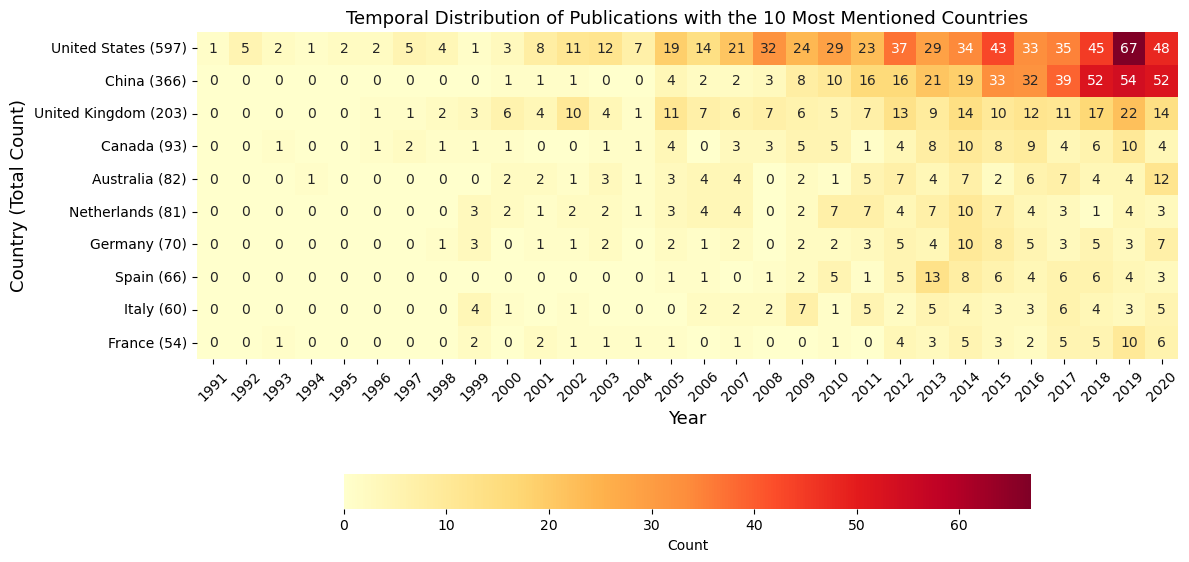

In [12]:
filtered_heatmap = create_filtered_heatmap(df_country, top_n=10)
filtered_heatmap.show()

## Preprocess keywords and generate statistics

In [33]:
def preprocess(df):
    df['Year'] = df['Year'].astype(int)
    df['Author Keywords'] = df['Author Keywords'].str.lower().str.split(';')

   # Convert all keywords to lowercase and strip leading/trailing whitespaces
    df['Author Keywords'] = df['Author Keywords'].apply(lambda x: [kw.strip() for kw in x])
    df_expanded = df.explode('Author Keywords')

    return df_expanded

df_keywords = preprocess(df)
df_keywords = df_keywords.reset_index(drop=True)

In [34]:
## Table 1 - Summary Statistics

# Group by journal and get min and max years, unique IDs, and keyword count
grouped = df_keywords.groupby('journal_abbr').agg(
    Time_Range=('Year', lambda x: f"{x.min()}-{x.max()}"),
    Paper_Count=('Id', 'nunique'),
    Keyword_Count=('Author Keywords', 'count')
)

# Calculate total paper and keyword count
total_paper_count = grouped['Paper_Count'].sum()
total_keyword_count = grouped['Keyword_Count'].sum()

# Create a new row for the total
total_row = pd.DataFrame({
    'Time_Range': [f"{df_keywords['Year'].min()}-{df_keywords['Year'].max()}"],
    'Paper_Count': total_paper_count,
    'Keyword_Count': total_keyword_count
}, index=['Total'])

grouped = pd.concat([grouped, total_row])
grouped

,Time_Range,Paper_Count,Keyword_Count
CEUS,1999-2020,622,3177
COSIT,1993-2019,22,100
CaGIS,1991-2020,196,1002
EPB,1998-2020,352,1744
GIScience,2006-2020,18,78
GeoI,1997-2020,61,305
IJGIS,2005-2020,550,2640
JGS,1996-2020,196,922
JOSIS,2010-2020,21,133
SCC,2003-2020,19,92
